In [2]:
import os
import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
import cv2 as cv
import tensorflow as tf

In [3]:
def create_spectrogram(y):
    spec = librosa.feature.melspectrogram(y=y)
    spec_conv = librosa.amplitude_to_db(spec, ref=np.max)
    return spec_conv
def save_spectrogram(spectrogram, file_name, classid):
    if str(classid) not in os.listdir("spectrograms"):
        os.mkdir(f"spectrograms/{classid}")

    save_name = file_name.split(".")[0]
    
    plt.figure()
    librosa.display.specshow(spectrogram)
    plt.savefig(f"spectrograms/{classid}/{save_name}.png", bbox_inches="tight", pad_inches=0)
    plt.close()

In [4]:
df = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
path_to_folds = "UrbanSound8K/audio"

if "spectrograms" not in os.listdir():
    os.mkdir("spectrograms")

number_of_files = df.shape[0]
number_of_processed = 0
number_of_errors = 0

In [6]:
with open("errors.txt", "w") as error_file:
    for index, row in df.iterrows():
        try:
            file_name = row["slice_file_name"]
            fold = row["fold"]
            classid = row["classID"]
            path_to_file = f"{path_to_folds}/fold{fold}/{file_name}"
                        
            data, sr = librosa.load(path_to_file)
            spectrogram = create_spectrogram(data)
            save_spectrogram(spectrogram, file_name, classid)
            
            del data
            del sr
            del spectrogram
            
        except Exception as e:
            number_of_errors += 1
            error_file.write(f"{number_of_errors}: {e}\n")
        
        finally:
            number_of_processed += 1
        
        print(f"\rNumber: {number_of_processed}/{number_of_files} | Errors: {number_of_errors}", end="")

Number: 3555/8732 | Errors: 0

c:\Users\Banisiri\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)


Number: 8327/8732 | Errors: 0

c:\Users\Banisiri\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)


Number: 8329/8732 | Errors: 0

c:\Users\Banisiri\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


Number: 8732/8732 | Errors: 0

In [7]:
images = []
number_of_errors = 0
number_of_processed = 0

for classid in os.listdir("spectrograms"):
    path_to_class = f"spectrograms/{classid}"
    for image in os.listdir(path_to_class):
        try:
            path_to_image = f"{path_to_class}/{image}"
            
            img = cv.imread(path_to_image, 0)
            img = cv.resize(img, (128,128))
            img = img/255
            images.append([img, int(classid)])
            number_of_processed += 1

        except:
            number_of_errors += 1
        
        print(f"\rProcessed: {number_of_processed} | Erros: {number_of_errors}", end="")

Processed: 8732 | Erros: 0

In [8]:
len(images)
for _ in range(10):
    random.shuffle(images)

In [9]:
X = []
y = []

for image, idx in images:
    X.append(image)
    y.append(idx)

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

X_train = X[:6293]
y_train = y[:6293]

X_val = X[6293:7079]
y_val = y[6293:7079]

X_test = X[7079:]
y_test = y[7079:]

In [10]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

6293
6293
786
786
1653
1653


In [11]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(-1, 128, 128, 1) 
X_val = X_val.reshape(-1, 128, 128, 1) 
X_test = X_test.reshape(-1, 128, 128, 1) 

In [12]:
if "pickles" not in os.listdir():
    os.mkdir("pickles")
with open("pickles/X_train.pickle", "wb") as f:
  pickle.dump(X_train, f)  
with open("pickles/y_train.pickle", "wb") as f:
  pickle.dump(y_train, f)
with open("pickles/X_val.pickle", "wb") as f:
  pickle.dump(X_val, f)  
with open("pickles/y_val.pickle", "wb") as f:
  pickle.dump(y_val, f)
with open("pickles/X_test.pickle", "wb") as f:
  pickle.dump(X_test, f)  
with open("pickles/y_test.pickle", "wb") as f:
  pickle.dump(y_test, f)

In [13]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), padding="same", input_shape=(128, 128, 1)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val))

Epoch 1/60
197/197 [==============================] - 48s 232ms/step - loss: 2.2278 - accuracy: 0.1397 - val_loss: 2.1333 - val_accuracy: 0.2455
Epoch 2/60
197/197 [==============================] - 44s 225ms/step - loss: 2.0776 - accuracy: 0.2086 - val_loss: 2.0416 - val_accuracy: 0.2443
Epoch 3/60
197/197 [==============================] - 45s 227ms/step - loss: 1.9755 - accuracy: 0.2500 - val_loss: 1.9195 - val_accuracy: 0.2977
Epoch 4/60
197/197 [==============================] - 45s 226ms/step - loss: 1.8894 - accuracy: 0.2701 - val_loss: 1.7586 - val_accuracy: 0.3206
Epoch 5/60
197/197 [==============================] - 50s 255ms/step - loss: 1.8377 - accuracy: 0.2827 - val_loss: 1.6583 - val_accuracy: 0.3321
Epoch 6/60
197/197 [==============================] - 46s 236ms/step - loss: 1.7687 - accuracy: 0.2848 - val_loss: 1.5515 - val_accuracy: 0.3422
Epoch 7/60
197/197 [==============================] - 46s 231ms/step - loss: 1.7227 - accuracy: 0.3068 - val_loss: 1.4923 - val_ac

In [15]:
result = model.evaluate(X_test, y_test)
print(f"Loss: {result[0]} - Accuracy: {result[1]}")

52/52 [==============================] - 4s 68ms/step - loss: 1.0484 - accuracy: 0.6564
Loss: 1.0484204292297363 - Accuracy: 0.6563823223114014


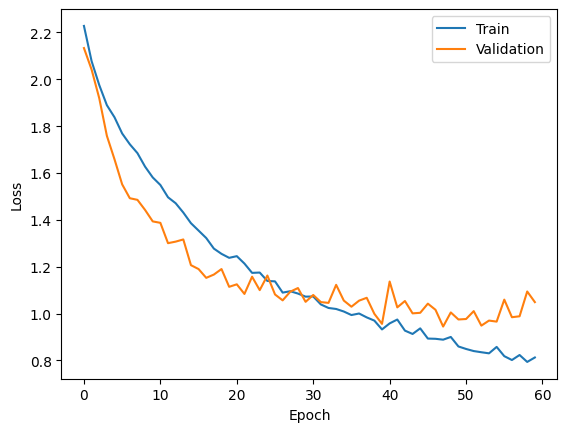

In [16]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

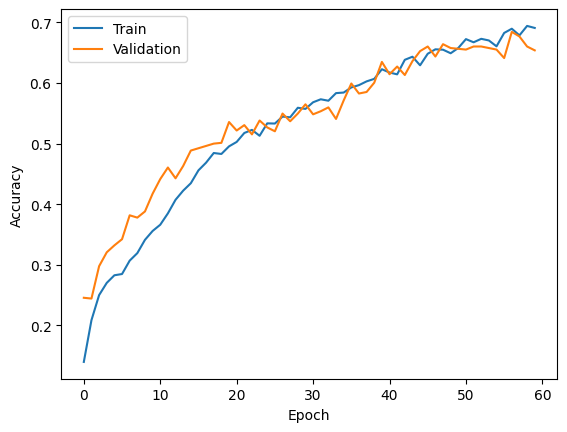

In [17]:
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()